In [1]:
# LSTM-Based Stock Price Prediction for MSFT.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Load Dataset
data = pd.read_csv("/content/drive/MyDrive/MSFT.csv")  # Replace with your file

In [3]:
# Ensure Date format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
# 2. Select Target Feature
closing_prices = data['Close'].values.reshape(-1,1)

In [5]:
# 3. Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

In [6]:
# 4. Prepare training data (80%-20% split)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size-60:]

In [7]:
# 5. Create dataset sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [8]:
# Reshape input for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
# 6. Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - loss: 0.0012
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 1.4218e-04
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 1.1140e-04
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 9.9145e-05
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - loss: 8.7732e-05
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 7.4172e-05
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 6.4177e-05
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 7.3577e-05
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 6.1291e-05
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 6.4960e-05
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 6.7948e-05
Epoch 12/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 6.2535e-05
Epoch 13/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 6.5257e-05
Epoch 14/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/s

In [12]:
# 7. Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [13]:
# Inverse transform y_test
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

In [14]:
# 8. Evaluation
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

print(f"\nModel Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}% Accuracy: {100 - mape:.2f}%")


Model Evaluation Metrics:
MAE: 2.83
RMSE: 4.36
R2 Score: 0.99
MAPE: 2.96% Accuracy: 97.04%


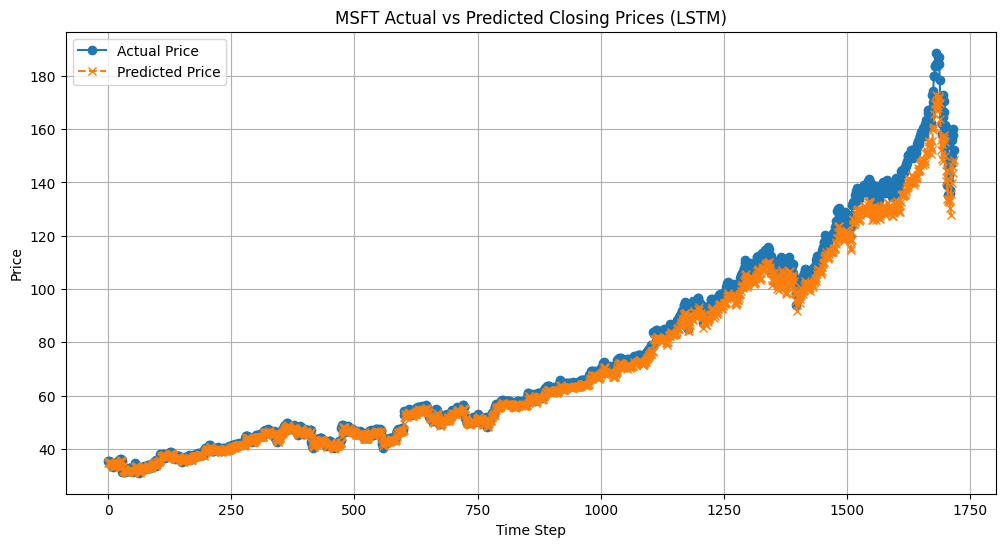

In [15]:
# 9. Visualizations

# Actual vs Predicted Prices
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price', marker='o')
plt.plot(predictions, label='Predicted Price', linestyle='--', marker='x')
plt.title('MSFT Actual vs Predicted Closing Prices (LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [17]:
import seaborn as sns

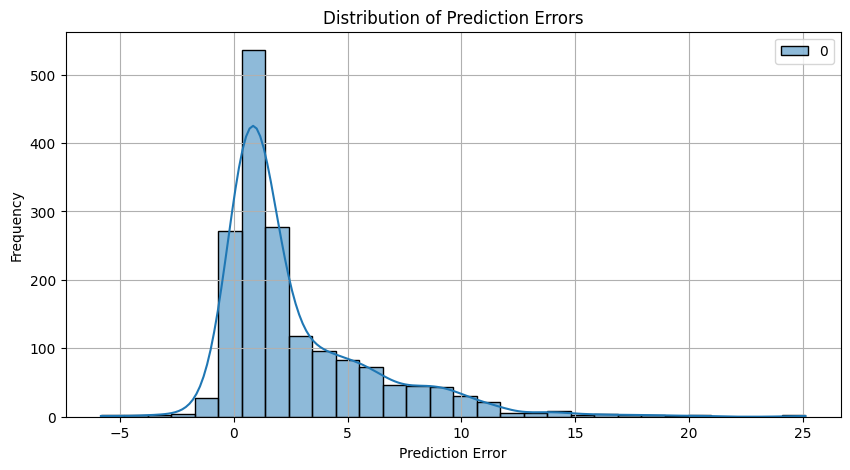

In [18]:
# Error Distribution
errors = y_test_actual - predictions
plt.figure(figsize=(10,5))
sns.histplot(errors, kde=True, color='red', bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

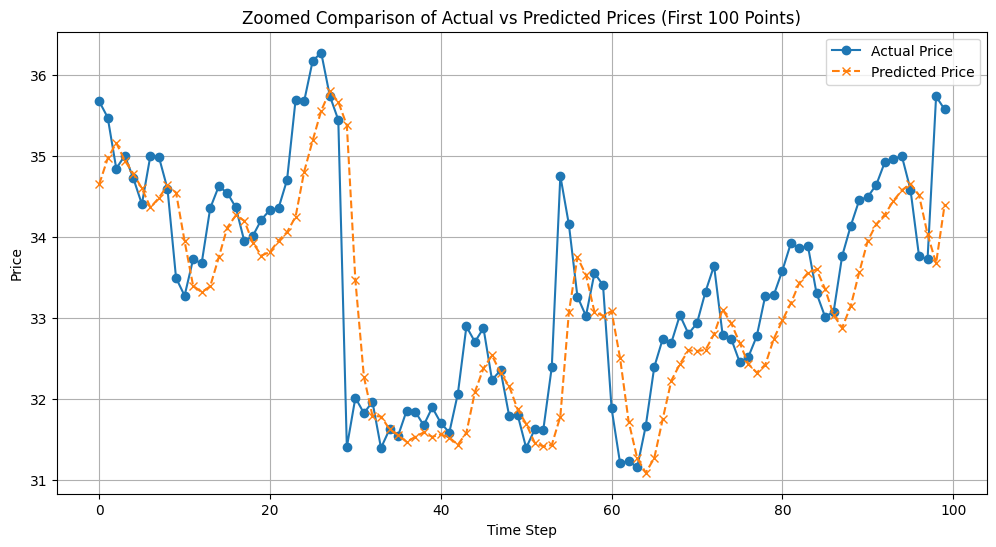

In [19]:
# Actual vs Predicted Line Comparison
plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:100], label='Actual Price', marker='o')
plt.plot(predictions[:100], label='Predicted Price', linestyle='--', marker='x')
plt.title('Zoomed Comparison of Actual vs Predicted Prices (First 100 Points)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [20]:
print("\n✅ Microsoft (MSFT) Stock Price Prediction using LSTM Completed Successfully!")


✅ Microsoft (MSFT) Stock Price Prediction using LSTM Completed Successfully!
